<a href="https://colab.research.google.com/github/BBudiharjo/tucson-crime-models/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO

# Model 1 - Multi-Variable Linear Regression on GIS Data

**inputs**: GIS data
    - number of ... included in subsection
        - sidewalk
        - bicycle boulevards
        - landfill
        - fire station
        - bridge
        - crosswalk
        - streetcar route
        - streetcar stop
        - scenic route
        - streetlight
        - suntran bus stop
    - characteristics of subsection
        - race
            - column for each main race (or arbitrary groupings)
            - proportion of total  
        - mean income
        - mean education level
        - mean age

**output**: number of crimes / time legth of data set
            (aka crime frequency)


## Development Process

1. Create subsections
    - function that takes:
        - number subsections
            - type: int
            - width/height        
        - returns list of:
            -`bbox` (bounding box)
                - type: `tuple[Float]`
                - (lat_lower, lat_upper, long_lower, long_upper)

2. Accumulating data from each appropriate dataset such that it's like:
    
    | num sidewalks | .... | characteristics | ... | total number of crimes |

3. Data cleaning

4. Split data into training and testing sets

5. Determining best regression type:
    - For each regression type, hyperpamater tuning (determine optimal params)
        - Best subsets
            - particular subset of features
        - Lasso reg
            - best lambda/alpha (LARS)
        - Ridge reg
            - best lambda/alpha
    - Choose best regression type

6. Use given regression type to fit model

7. (hyperparamater tuning ?)

8. Evaluate model, reflect, make changes (repeat at step 5)
    - Choose some ...
        - arbitrary metric
        - significance level
        - baseline model
        - real model developed in actual scientific literature that does same thing
            - theres also a section of the report "Related Works" for this

# Model 2 - ...

want to:

- use other concepts from class like
    - qualitative outputs (logistic regression)
    - support vectors
    - ...

## Development Process

in general, similar to model 1 development process
- [ ] Use a more efficient method of joining data by geographic distance. E.g., connecting arrest incidents with nearest sidewalk. Current method could take hours with 50k arrests dataset.
- [ ] When making Folium maps (geographic maps with popup markers on them), use a plotting technique more appropriate to the data (refer to lecture slides). E.g., a heat map, contour plot, hexagon scatter plot.
- [ ] In the [datasets](https://github.com/christian-byrne/tucson-crime-models/tree/main/data), go to `infrastructure` folder, choose other infrastructure datasets (e.g., `streetlights`), and explore correlations in the same way it's been done for sidewalks in [Analzing correlation between distance to sidewalks and arrest frequency](https://colab.research.google.com/github/christian-byrne/tucson-crime-models/blob/main/main.ipynb#scrollTo=q-fOMfTsP1vG&line=1&uniqifier=1)
- ...Explore other trends in the data with other approaches. See these [suggestions given by LLM](https://github.com/christian-byrne/tucson-crime-models/blob/main/doc/correlation-discovery.md)


## Utils

### Configuration

In [ ]:
from pathlib import Path
from typing import Union, Dict, Any


class Config:
    # Embedded configuration data
    _config_data: Dict[str, Any] = {
        "log_level": "DEBUG",
        "tucson_center_coordinates": [32.2226, -110.9747],
        "tucson_bounds": [-111, 32.0, -110.9747, 32.2226],
        "paths": {"visualizations": "visualizations"},
        "data_sources": {
            "arrests": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/crime/Tucson_Police_Arrests_-_2017_-_Open_Data.geojson",
            "sidewalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Sidewalks.geojson",
        },
    }

    # Root path for resolving paths
    ROOT_PATH: Path = Path(".").resolve()

    @staticmethod
    def get_proj_root(cls) -> Path:
        """Return the root path of the project."""
        return Config.ROOT_PATH

    def __getitem__(self, key: str) -> Any:
        """Get a configuration value by key, with KeyError if missing."""
        if key not in Config._config_data:
            msg = (
                f"Could not find key '{key}' in config."
                + f"Available keys: {list(Config._config_data.keys())}"
            )
            raise KeyError(msg)
        return Config._config_data[key]

    def __setitem__(self, key: str, value: Union[str, Path]) -> None:
        """Set a configuration value by key, converting Path to string if necessary."""
        if isinstance(value, Path):
            value = str(value.resolve())
        Config._config_data[key] = value

    @classmethod
    def get_all(cls) -> Dict[str, Any]:
        """Return the entire configuration data dictionary."""
        return cls._config_data

config = Config()

### Logging

In [ ]:
import logging
from rich.logging import RichHandler


class Logger:
    def __init__(self, logger_name: str, level: int = logging.INFO):
        self.logger_base = logging.getLogger(logger_name)

        # Ensure no handlers are duplicated and set propagate to False
        self.logger_base.handlers.clear()
        self.logger_base.propagate = False

        rich_handler = RichHandler(
            rich_tracebacks=True, tracebacks_show_locals=True, markup=True
        )

        formatter = logging.Formatter("%(message)s")
        rich_handler.setFormatter(formatter)

        self.logger_base.addHandler(rich_handler)
        self.logger_base.setLevel(level)

    def __call__(self):
        return self.logger_base


logger = Logger("General", config["log_level"])()

### File Loading

In [ ]:
import geopandas as gpd
import requests
from typing import Dict

# Dictionary to cache datasets in memory to prevent re-fetching in same session
_cache: Dict[str, gpd.GeoDataFrame] = {}


def load_dataset(dataset_name: str):
    # Check if the dataset is already cached
    if dataset_name in _cache:
        logger.info(f"Using cached data for {dataset_name}")
        return _cache[dataset_name]

    # Load the dataset from Config if not cached
    filepath = config["data_sources"][dataset_name]

    if filepath.startswith("http"):
        logger.info(f"Downloading dataset from {filepath}")
        response = requests.get(filepath)
        response.raise_for_status()
        with open(f"/tmp/{dataset_name}.geojson", "wb") as f:
            f.write(response.content)
        dataframe = gpd.read_file(f"/tmp/{dataset_name}.geojson")
    else:
        dataframe = gpd.read_file(filepath)

    logger.info(f"Loaded data from {filepath}")
    logger.debug(
        f"Columns in {filepath.split('/')[-1]}:\n{', '.join(dataframe.columns)}"
    )

    # Cache the loaded dataset
    _cache[dataset_name] = dataframe

    return dataframe

### Exploratory Data Analysis

#### Data Cleaning

##### Filter Geographic Information System (GIS) Data by Bounds

In [ ]:
import folium
import geopandas as gpd
from shapely.geometry import box


def filter_by_bounds(data: gpd.GeoDataFrame, bounds: tuple) -> gpd.GeoDataFrame:
    """
    Filters the GeoDataFrame to include only points within the specified bounds.

    Parameters:
    data (GeoDataFrame): The data to filter.
    bounds (tuple): A tuple (minx, miny, maxx, maxy) defining the bounding box.

    Returns:
    GeoDataFrame: Filtered GeoDataFrame with points within the bounds.
    """
    logger.debug(f"Filtering data by bounds: {bounds}")
    bbox = box(*bounds)

    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")
        return data

    # Filter data by checking if geometry is within the bounding box
    filtered = data[data.geometry.within(bbox)]
    logger.info(f"Filtered out {len(data) - len(filtered)} rows outside the bounds. {len(filtered)} rows remaining.")

    if len(data) == len(filtered):
        logger.warning("All data is within the specified bounds. No data was filtered.")

    if len(filtered) == 0:
        logger.error(
            f"All data was filtered out. Check that the bounds {bounds} are correct."
        )

    return filtered

#### Data Visualization

##### Plot GIS Data on a Geographic Map

In [ ]:
from typing import Optional


def create_map(
    data: gpd.GeoDataFrame,
    location: list = None,
    zoom_start: int = 12,
    popup_field: Optional[str] = None,
    save_path: Union[str, Path, None] = None,
):
    """
    Create a folium map with markers for each point in the input GeoDataFrame.

    Parameters:
    data (GeoDataFrame): The data to plot, must contain 'geometry' column.
    location (list): Latitude and longitude to center the map on. Default is Tucson, AZ.
    zoom_start (int): Initial zoom level for the map.
    popup_field (str, optional): Column name to use for the marker popups. If None, no popups.
    save_path (str or Path, optional): Path to save the generated map HTML file.

    Returns:
    folium.Map: A map with a marker for each point in data.
    """
    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")

    # Default location to Tucson, AZ if not provided
    location = location or [32.2226, -110.9747]

    logger.info(f"Creating map centered at {location} with zoom level {zoom_start}...")
    map_canvas = folium.Map(location=location, zoom_start=zoom_start)

    logger.debug("Filtering out rows with missing or non-Point geometry")
    data = data[data.geometry.notnull() & (data.geometry.type == "Point")]

    logger.info(f"Adding {len(data)} points to the map")
    for _, row in data.iterrows():
        # Retrieve the popup content if specified and available
        popup_text = (
            str(row[popup_field]) if popup_field and popup_field in row else None
        )
        folium.Marker([row.geometry.y, row.geometry.x], popup=popup_text).add_to(
            map_canvas
        )

    # Save map to HTML if save_path is specified
    if save_path:
        save_path = Path(save_path) if isinstance(save_path, str) else save_path
        map_canvas.save(save_path)
        logger.info(f"Map saved at {save_path}")

    # Display the map inline in the notebook
    # display(map_canvas) # NOTE: this happens automatically in collab

    return map_canvas

#### Data Joining

In [ ]:
def join_data(
    left: gpd.GeoDataFrame,
    right: gpd.GeoDataFrame,
    left_key: str,
    right_key: str,
    how: str = "left",
) -> gpd.GeoDataFrame:
    """
    Join two GeoDataFrames based on a common key.

    Parameters:
    left (GeoDataFrame): The left GeoDataFrame to join.
    right (GeoDataFrame): The right GeoDataFrame to join.
    left_key (str): The column name to join on in the left GeoDataFrame.
    right_key (str): The column name to join on in the right GeoDataFrame.
    how (str): The type of join to perform. Default is 'left'.

    Returns:
    GeoDataFrame: A GeoDataFrame with the joined data.
    """
    logger.info(f"Joining data on {left_key} with {right_key} using {how} join")
    joined = left.merge(right, how=how, left_on=left_key, right_on=right_key)

    if len(joined) == 0:
        logger.error(
            f"No data was joined. Check that the keys {left_key} and {right_key} are correct."
        )

    return joined

##### Join GIS Data based on Distance Comparisons

In [ ]:
# NOTE: This approach works well for moderately sized datasets but could become slow for very large ones. For large datasets, spatial indexing or more advanced spatial joins might be needed (e.g., using scipy’s cKDTree for faster nearest-neighbor searches).
def distance_join(
    main_gdf, ref_gdf, ref_col_name="nearest_id", distance_col_name="distance_to"
):
    """
    Adds a column to the main GeoDataFrame with the ID of the nearest feature
    from the reference GeoDataFrame.

    Parameters:
    main_gdf (GeoDataFrame): The main GeoDataFrame, typically with Point geometries (e.g., arrests data).
    ref_gdf (GeoDataFrame): The reference GeoDataFrame to find the nearest feature from (e.g., sidewalks).
    ref_col (str): The name of the new column in main_gdf to store the ID of the nearest feature.
    distance_col (str, optional): If provided, stores the distance to the nearest feature in this column.

    Returns:
    GeoDataFrame: The main GeoDataFrame with an added column for the nearest feature's ID.
    """
    # Ensure both GeoDataFrames are in the same CRS, convert to a metric CRS for distance calculation
    metric_crs = "EPSG:3857"
    main_gdf = main_gdf.to_crs(metric_crs)
    ref_gdf = ref_gdf.to_crs(metric_crs)

    # Prepare the new columns in main_gdf
    main_gdf[ref_col_name] = None
    if distance_col_name:
        main_gdf[distance_col_name] = None

    # For each geometry in main_gdf, find the closest geometry in ref_gdf
    for idx, main_geom in main_gdf.iterrows():
        # Find the nearest geometry in ref_gdf
        nearest_geom = ref_gdf.geometry.distance(main_geom.geometry).idxmin()

        # Add the ID of the nearest geometry (index) to the main_gdf
        main_gdf.at[idx, ref_col_name] = ref_gdf.at[
            nearest_geom, "OBJECTID"
        ]  # or another ID column in ref_gdf

        # Optionally, store the distance to the nearest feature
        if distance_col_name:
            distance = main_geom.geometry.distance(ref_gdf.at[nearest_geom, "geometry"])
            main_gdf.at[idx, distance_col_name] = distance

    # Reproject main_gdf back to the original CRS
    main_gdf = main_gdf.to_crs(ref_gdf.crs)

    return main_gdf

## Main

#### Load *Arrests* Data

In [ ]:
arrests_data = load_dataset("arrests")

[11/10/24 17:46:52] INFO     Downloading dataset from                             ]8;id=866501;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=398530;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/crime/Tucson_Police_Arre                                  
                             sts_-_2017_-_Open_Data.geojson                                                        

[11/10/24 17:47:18] INFO     Loaded data from                                     ]8;id=114316;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=726742;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/crime/Tucson_Police_Arre                                  
                             sts_-_2017_-_Open_Data.geojson                                                        

                    DEBUG    Columns in                                           ]8;id=105582;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=139299;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             Tucson_Police_Arrests_-_2017_-_Open_Data.geojson:                                     
                             OBJECTID, X, Y, agency, arre_id, case_id, date_arr,                                   
                             time_arr, datetime_arr, MONTH_ARR, YEAR_ARR,                                          
                             DOW_ARR, TIME_ARRST, age, race, sex, ethnicity,                                       
                             arr_type, neighborhd, ADDRESS_PUBLIC, city, state,                                    
                             zip, arr_chrg, chrgdesc, chrg_cnt, fel_misd,                                          
                             chrg_seq, APPSTATE, LOC_STATUS, WARD, NHA_NAME,                                       
                             DIVISION, DIVISION_NO, DIVSECT, TRSQ, LOC_METHOD,                                     
                             geometry                                                                              

#### Clean Data

In [ ]:
# Remove records with no geometry/location data
# (TODO: consult slides for other approaches to records with missing fields)
arrests_data = arrests_data[arrests_data.geometry.notnull()]

#### Truncate/Shrink Data for Fast Testing (Temporary)

In [ ]:
# Restrict to just Tucson
arrests_data = filter_by_bounds(arrests_data, config["tucson_bounds"])

# Truncate
arrests_data = arrests_data.head(1000)

                    DEBUG    Filtering data by bounds: [-111, 32.0, -110.9747,    ]8;id=346073;file://<ipython-input-4-628a12a4daad>\<ipython-input-4-628a12a4daad>]8;;\:]8;id=824313;file://<ipython-input-4-628a12a4daad>#17\17]8;;\
                             32.2226]                                                                              

                    INFO     Filtered out 56262 rows outside the bounds. 6694     ]8;id=426730;file://<ipython-input-4-628a12a4daad>\<ipython-input-4-628a12a4daad>]8;;\:]8;id=270775;file://<ipython-input-4-628a12a4daad>#26\26]8;;\
                             rows remaining.                                                                       

#### Visualize Arrests Data

In [ ]:
create_map(arrests_data, popup_field="ArrestChargeandDescription")

                    INFO     Creating map centered at [32.2226, -110.9747] with   ]8;id=497809;file://<ipython-input-5-e960f8a72a7f>\<ipython-input-5-e960f8a72a7f>]8;;\:]8;id=260177;file://<ipython-input-5-e960f8a72a7f>#30\30]8;;\
                             zoom level 12...                                                                      

                    DEBUG    Filtering out rows with missing or non-Point         ]8;id=54496;file://<ipython-input-5-e960f8a72a7f>\<ipython-input-5-e960f8a72a7f>]8;;\:]8;id=399443;file://<ipython-input-5-e960f8a72a7f>#33\33]8;;\
                             geometry                                                                              

                    INFO     Adding 1000 points to the map                        ]8;id=57176;file://<ipython-input-5-e960f8a72a7f>\<ipython-input-5-e960f8a72a7f>]8;;\:]8;id=674140;file://<ipython-input-5-e960f8a72a7f>#36\36]8;;\

#### Load *Sidewalks* Data

In [ ]:
sidewalks_data = load_dataset("sidewalks")

[11/10/24 17:47:19] INFO     Downloading dataset from                             ]8;id=998635;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=747178;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Sidewalks                                  
                             .geojson                                                                              

[11/10/24 17:47:26] INFO     Loaded data from                                     ]8;id=707364;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=954390;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Sidewalks                                  
                             .geojson                                                                              

                    DEBUG    Columns in Sidewalks.geojson:                        ]8;id=129088;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=348689;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             OBJECTID, DATASOURCE, ShapeSTLength, geometry                                         

#### Add `distance_to_nearest_sidewalk` to Arrests Data

In [ ]:
arrests_data = distance_join(
    arrests_data,
    sidewalks_data,
    ref_col_name="nearest_sidewalk_id",
    distance_col_name="distance_to_nearest_sidewalk",
)

#### Analyze Correlation between Arrests Frequency and `distance_to_nearest_sidewalk`

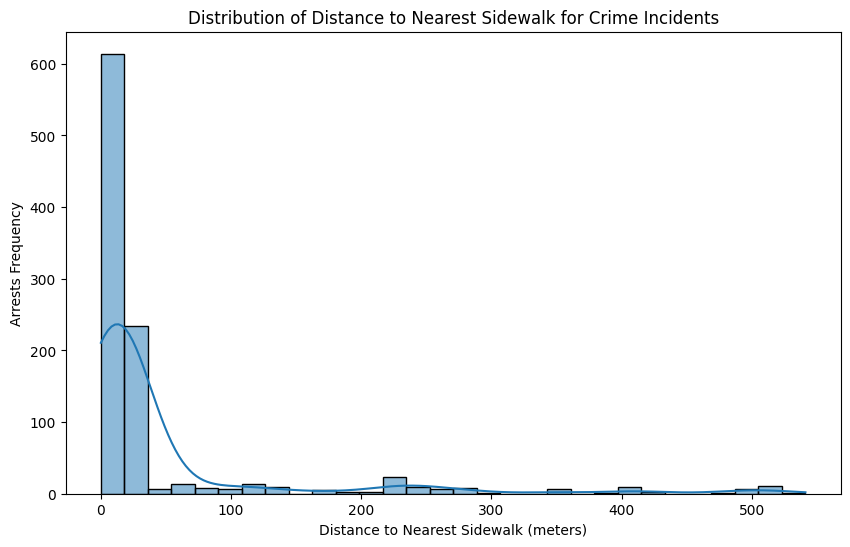

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(arrests_data["distance_to_nearest_sidewalk"], kde=True, bins=30)
plt.xlabel("Distance to Nearest Sidewalk (meters)")
plt.ylabel("Arrests Frequency")
plt.title("Distribution of Distance to Nearest Sidewalk for Crime Incidents")
plt.show()

In [ ]:
import folium

TUCSON_BOUNDS = [-111, 32.0, -110.9747, 32.2226]

def create_subsections(number, bbox):
    """
    Params:
    number: int - number of subsections
    bbox: tuple[Float] - (lat_lower, lat_upper, long_lower, long_upper) - bounding box of the area to be divided

    Returns:
    subsections: list[tuple[Float]] -
      list of tuples (lat_lower, lat_upper, long_lower, long_upper) representing the subsections of the area

    """
    lat_lower, lat_upper, long_lower, long_upper = bbox
    lat_step = (lat_upper - lat_lower) / number
    long_step = (long_upper - long_lower) / number

    subsections = []
    for i in range(number):
        for j in range(number):
            subsections.append(
                (
                    lat_lower + i * lat_step,
                    lat_lower + (i + 1) * lat_step,
                    long_lower + j * long_step,
                    long_lower + (j + 1) * long_step,
                )
            )
    return subsections

# Adjusting the visualization function for bounding box interpretation
def visualize_subsections_on_map(subsections, center_coordinates, zoom_start=12):
    """
    Visualize the geographical subsections on a Folium map.

    Parameters:
    subsections: list[tuple[float]] - List of bounding boxes for subsections in (lat_lower, lat_upper, long_lower, long_upper) format.
    center_coordinates: list[float] - Coordinates to center the map on.
    zoom_start: int - Initial zoom level for the map.

    Returns:
    folium.Map: The Folium map with subsections visualized.
    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(location=center_coordinates, zoom_start=zoom_start)

    # Add rectangles for each subsection
    for subsection in subsections:
        lat_lower, lat_upper, long_lower, long_upper = subsection
        # Ensure the bounds are in the correct order for Folium
        bounds = [[lat_lower, long_lower], [lat_upper, long_upper]]
        folium.Rectangle(bounds, color="blue", fill=True, fill_opacity=0.2).add_to(folium_map)

    return folium_map

# Define the Tucson center coordinates and bounds
tucson_center_coordinates = [32.2226, -110.9747]
tucson_bounds = [32.0, 32.2226, -111, -110.9747]

# Generate subsections
test_sections = create_subsections(4, tucson_bounds)

# Visualize on map
map_with_subsections = visualize_subsections_on_map(test_sections, tucson_center_coordinates)
map_with_subsections
